### Import Libraries

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Read Dataset

In [ ]:
train_dir = 'Data/fer/train'
test_dir = 'Data/fer/test'

classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

#### Create PyTorch DataLoader

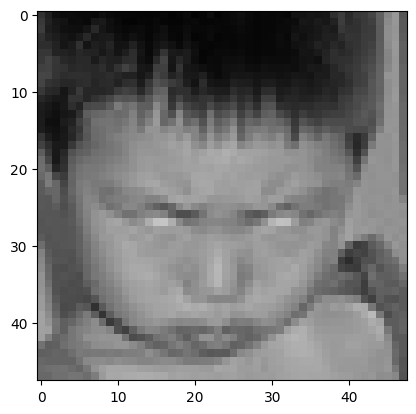

In [7]:
test_im_path = train_dir + '/angry/Training_10118481.jpg'
im = cv2.imread(test_im_path)
plt.imshow(im)
plt.show()

In [8]:
im_width, im_height = (128, 128)
class ImageDataset(Dataset):
    def __init__(self, im_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((im_height, im_width))
        self.im_dir = im_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.im_paths, self.im_labels = self.read_im_files()

        if split in ['train', 'val'] and 'train' in im_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.im_paths, self.im_labels)),
                train_size=train_ratio,
                random_state=random_seed,
                stratify=self.im_labels
            )

            if split == 'train':
                self.im_paths, self.im_labels = zip(*train_data)
            elif split == 'val':
                self.im_paths, self.im_labels = zip(*val_data)

    def read_im_files(self):
        im_paths, im_labels = [], []
        for cls in self.label2idx.keys():
            for im in os.listdir(os.path.join(self.im_dir, cls)):
                im_paths.append(os.path.join(self.im_dir, cls, im))
                im_labels.append(cls)

        return im_paths, im_labels

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = read_image(im_path)
        im = self.resize(im)
        im = im.type(torch.float32)
        label = self.label2idx[self.im_labels[idx]]
        if self.norm:
            im = (im / 127.5) - 1
        return im, label

In [9]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, 'train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

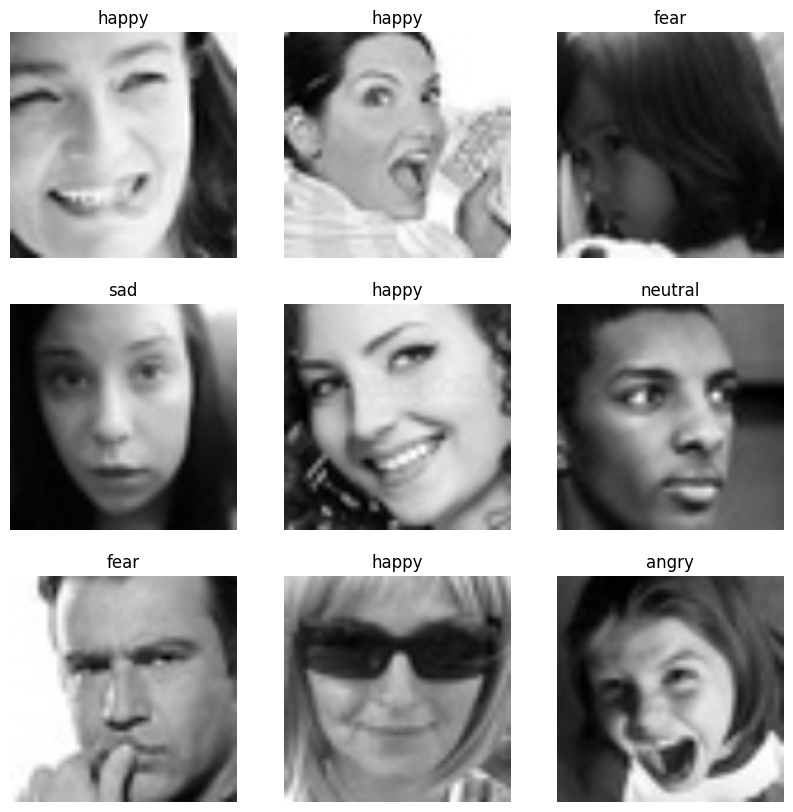

In [11]:
im_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = im_batch[i].numpy().min()
    maxv = im_batch[i].numpy().max()
    plt.imshow(np.squeeze(im_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(idx2label[label_batch[i].item()])
    plt.axis('off')
plt.show()

### Build MLP Network

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim * 4)
        self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.linear3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [13]:
input_dim = im_height * im_width
output_dim = len(classes)
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

In [14]:
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
def compute_accuracy(y_pred, y):
    _, y_pred = torch.max(y_pred, dim=1)
    correct = (y_pred == y).sum().item()
    return correct / y.shape[0]

### Train

In [16]:
epochs = 40
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(y_pred.detach().cpu())
        train_target.append(y_batch.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.append(y_pred.cpu())
            val_target.append(y_batch.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

Epoch 1/40:	train_loss: 1.908	val_loss: 1.882
Epoch 2/40:	train_loss: 1.853	val_loss: 1.834
Epoch 3/40:	train_loss: 1.814	val_loss: 1.809
Epoch 4/40:	train_loss: 1.793	val_loss: 1.793
Epoch 5/40:	train_loss: 1.779	val_loss: 1.780
Epoch 6/40:	train_loss: 1.766	val_loss: 1.767
Epoch 7/40:	train_loss: 1.752	val_loss: 1.753
Epoch 8/40:	train_loss: 1.736	val_loss: 1.735
Epoch 9/40:	train_loss: 1.716	val_loss: 1.714
Epoch 10/40:	train_loss: 1.693	val_loss: 1.689
Epoch 11/40:	train_loss: 1.670	val_loss: 1.669
Epoch 12/40:	train_loss: 1.652	val_loss: 1.654
Epoch 13/40:	train_loss: 1.637	val_loss: 1.644
Epoch 14/40:	train_loss: 1.625	val_loss: 1.636
Epoch 15/40:	train_loss: 1.616	val_loss: 1.627
Epoch 16/40:	train_loss: 1.607	val_loss: 1.621
Epoch 17/40:	train_loss: 1.598	val_loss: 1.617
Epoch 18/40:	train_loss: 1.589	val_loss: 1.611
Epoch 19/40:	train_loss: 1.581	val_loss: 1.604
Epoch 20/40:	train_loss: 1.573	val_loss: 1.600
Epoch 21/40:	train_loss: 1.565	val_loss: 1.600
Epoch 22/40:	train_los

### Evaluation

In [17]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.4096133751306165


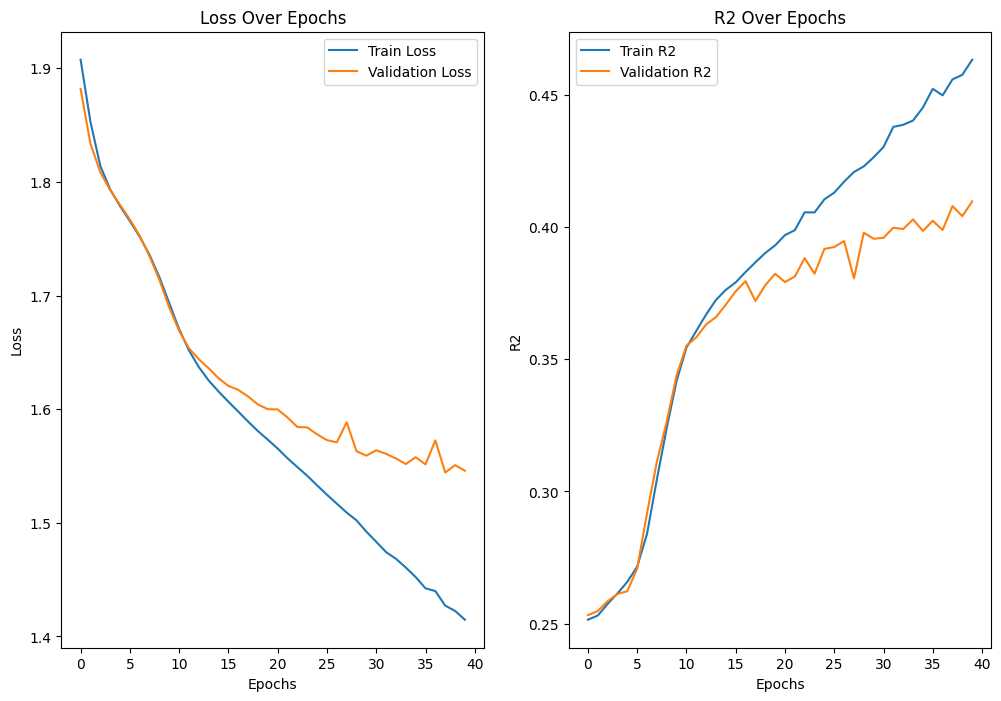

In [18]:
# Plot those loss and r2 on 2x2 plot
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

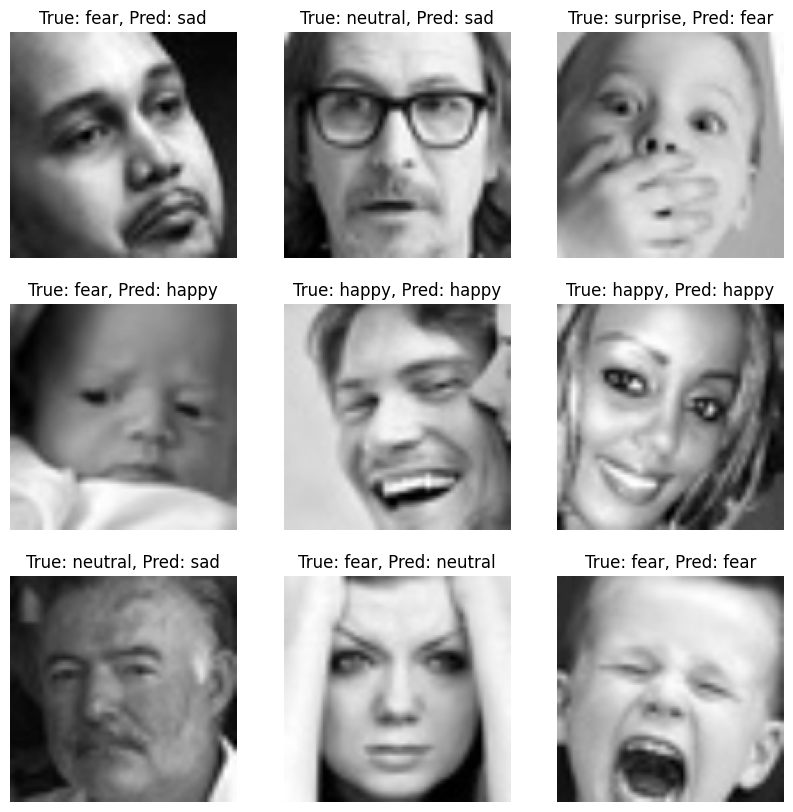

In [21]:
model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(val_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    _, y_pred_labels = torch.max(y_pred, dim=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = X_batch[i].cpu().numpy().min()
    maxv = X_batch[i].cpu().numpy().max()
    plt.imshow(np.squeeze(X_batch[i].cpu().numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(f"True: {idx2label[y_batch[i].item()]}, Pred: {idx2label[y_pred_labels[i].item()]}")
    plt.axis('off')
plt.show()

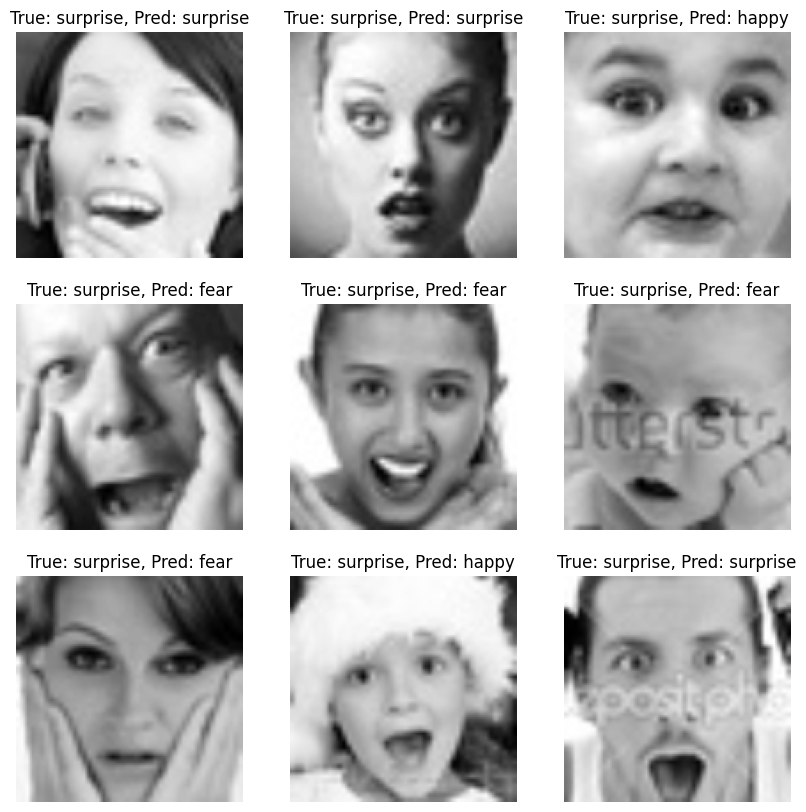

In [20]:
model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(test_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    _, y_pred_labels = torch.max(y_pred, dim=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = X_batch[i].cpu().numpy().min()
    maxv = X_batch[i].cpu().numpy().max()
    plt.imshow(np.squeeze(X_batch[i].cpu().numpy()), vmin=minv, vmax=maxv, cmap='gray')
    plt.title(f"True: {idx2label[y_batch[i].item()]}, Pred: {idx2label[y_pred_labels[i].item()]}")
    plt.axis('off')
plt.show()